# SETUP

In [1]:
import pandas as pd

import numpy as np

import pydicom as dicom

import matplotlib.pyplot as plt

from glob import glob

import seaborn as sns

import cv2

import torch
import torchvision

import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, Subset
from torch.utils.data import ConcatDataset
import torchvision.models as models
import torch.optim as optim
from torchvision import models

from transformers import ViTForImageClassification, ViTFeatureExtractor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

from PIL import Image

import timm

import os

from tqdm import tqdm

import random

import gc

import warnings

import time

warnings.filterwarnings("ignore")
%matplotlib inline

2024-09-22 14:43:43.921071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 14:43:43.921173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 14:43:44.054737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print('seeding done!!!')

def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    print('Memory Flushed')

In [3]:
seeding(2024)
flush()

seeding done!!!
Memory Flushed


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "/kaggle/input/d/bobiminhhuy/spine-mri-nchu/Original"
batch_size = 16
num_classes = 1  # Binary classification (Patient, Healthy)

print("Device: ", device)

Device:  cuda


# BUILDING DATASET

## Create file paths

In [5]:
# Function to create a list of image file paths
def make_datapath_list(root_dir):
    data_paths = []
    class_names = os.listdir(root_dir)
    
    for class_name in class_names:
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                data_paths.append((image_path, class_name))
    
    return data_paths

# Function to create a list of 'Healthy' image file paths
def make_healthy_datapath_list(root_dir):
    data_paths = []
    target_path = os.path.join(root_dir, 'Healthy', '*.jpg')
    
    for path in glob(target_path):
        data_paths.append((path, 'Healthy'))
    
    return data_paths

## Create Dataset Class

In [6]:
# Dataset class for Spine images
class SpineDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.transform = transform
        self.class_to_index = {'Healthy': 0, 'Patient': 1}

    def __len__(self):
        return len(self.data_paths)
    
    def get_labels(self):
        labels = [label for _, label in self.data_paths]
        label_indices = [self.class_to_index[label] for label in labels]
        return label_indices

    def __getitem__(self, idx):
        image_path, label = self.data_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label_idx = self.class_to_index[label]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        
        return {'image': image, 'label': label_tensor}

# Dataset class for Healthy Spine images with augmented transforms
class HealthySpineDataset(Dataset):
    def __init__(self, data_paths, transform=None):
        self.data_paths = data_paths
        self.transform = transform
        self.class_to_index = {'Healthy': 0, 'Patient': 1}

    def __len__(self):
        return len(self.data_paths)
    
    def get_labels(self):
        labels = [label for _, label in self.data_paths]
        label_indices = [self.class_to_index[label] for label in labels]
        return label_indices

    def __getitem__(self, idx):
        image_path, label = self.data_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        label_idx = self.class_to_index[label]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        
        return {'image': image, 'label': label_tensor}

# Custom ConcatDataset to get labels
class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super(CustomConcatDataset, self).__init__(datasets)
    
    def get_labels(self):
        results = []
        for dataset in self.datasets:
            if hasattr(dataset, 'get_labels'):
                results.extend(dataset.get_labels())
        return results

In [7]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augmented_train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augmented_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
# Create datapath lists
spine_datapath = make_datapath_list(root_dir)

# spine_train_datapath, spine_val_datapath = train_test_split(spine_datapath, test_size=0.2, random_state=42)

# First split: 70% train, 30% temp (validation + test)
spine_train_datapath, temp_datapath = train_test_split(spine_datapath, test_size=0.3, random_state=42)

# Second split: 20% of original total for validation and 10% for test
spine_val_datapath, spine_test_datapath = train_test_split(temp_datapath, test_size=0.5, random_state=42)


spine_train_dataset = SpineDataset(spine_train_datapath, transform=train_transform)
spine_val_dataset = SpineDataset(spine_val_datapath, transform=val_transform)
spine_test_dataset = SpineDataset(spine_test_datapath, transform=val_transform)

augmented_spine_train_dataset = HealthySpineDataset(spine_train_datapath, transform=augmented_train_transform)
# augmented_healthy_spine_val_dataset = HealthySpineDataset(healthy_spine_val_datapath, transform=val_transform)

spine_train_dataset = CustomConcatDataset([spine_train_dataset, augmented_spine_train_dataset])
#combined_spine_val_dataset = CustomConcatDataset([spine_val_dataset, augmented_healthy_spine_val_dataset])

In [9]:
# Get the sizes of the datasets
spine_train_size = len(spine_train_dataset)
spine_val_size = len(spine_val_dataset)
spine_test_size = len(spine_test_dataset)
# healthy_train_size = len(augmented_healthy_spine_train_dataset)
# healthy_val_size = len(augmented_healthy_spine_val_dataset)
# combined_train_size = len(combined_spine_train_dataset)
# combined_val_size = len(combined_spine_val_dataset)

# Print the sizes
print(f"Size of spine_train_dataset: {spine_train_size}")
print(f"Size of spine_val_dataset: {spine_val_size}")
print(f"Size of spine_test_dataset: {spine_test_size}")
# print(f"Size of augmented_healthy_spine_train_dataset: {healthy_train_size}")
# print(f"Size of augmented_healthy_spine_val_dataset: {healthy_val_size}")
# print(f"Size of combined_spine_train_dataset: {combined_train_size}")
# print(f"Size of combined_spine_val_dataset: {combined_val_size}")

Size of spine_train_dataset: 400
Size of spine_val_dataset: 43
Size of spine_test_dataset: 44


## Create DataLoader

In [10]:
# Training DataLoader
spine_train_loader = DataLoader(
    spine_train_dataset,
    batch_size=batch_size,
)

# Validation DataLoader
spine_val_loader = DataLoader(
    spine_val_dataset,
    batch_size=batch_size,
)

# Validation DataLoader
spine_test_loader = DataLoader(
    spine_test_dataset,
    batch_size=batch_size,
)

In [11]:
# # DataLoader with WeightedRandomSampler
# batch_size = 16
# class_weights = torch.tensor([1, 1], dtype=torch.float)

# # Training DataLoader
# train_labels = spine_train_dataset.get_labels()
# samples_weights = class_weights[train_labels]
# sampler = WeightedRandomSampler(weights=samples_weights, 
#                                 num_samples=len(samples_weights), 
#                                 replacement=True)

# spine_train_loader = DataLoader(
#     spine_train_dataset,
#     batch_size=batch_size,
#     sampler=sampler
# )

# # Validation DataLoader
# val_labels = spine_val_dataset.get_labels()
# samples_weights = class_weights[val_labels]
# sampler = WeightedRandomSampler(weights=samples_weights, 
#                                 num_samples=len(samples_weights), 
#                                 replacement=True)

# spine_val_loader = DataLoader(
#     spine_val_dataset,
#     batch_size=batch_size,
#     sampler=sampler
# )

## Show images in the dataset

In [12]:
# def imshow(img, ax):
#     """Function to show an image"""
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     ax.imshow(np.transpose(npimg, (1, 2, 0)))
#     ax.axis('off')

# def show_images_from_loader(loader, num_images_per_row=16):
#     """Function to show images from a DataLoader in a grid"""
#     for batch in loader:
#         images = batch['image']
#         labels = batch['label']
        
#         num_images = images.size(0)
#         num_rows = (num_images + num_images_per_row - 1) // num_images_per_row
        
#         fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(num_images_per_row * 2, num_rows * 2))
#         fig.suptitle('Images and Labels')
        
#         for i in range(num_images):
#             row = i // num_images_per_row
#             col = i % num_images_per_row
#             ax = axes[row, col] if num_rows > 1 else axes[col]
#             imshow(images[i], ax)
#             ax.set_title(f'Label: {labels[i].item()}')

#         # Hide any unused subplots
#         for i in range(num_images, num_rows * num_images_per_row):
#             row = i // num_images_per_row
#             col = i % num_images_per_row
#             ax = axes[row, col] if num_rows > 1 else axes[col]
#             ax.axis('off')

#         plt.show()

# # Assuming spinal_train_loader and spinal_val_loader are already defined
# # Display images from the training dataset
# print("Training Dataset Images:")
# show_images_from_loader(spine_train_loader)

# # Display images from the validation dataset
# print("Validation Dataset Images:")
# show_images_from_loader(spine_val_loader)

# BUILD MODEL

In [13]:
# # Load the EfficientNet model with pretrained weights
# spine_model = models.efficientnet_v2_s(pretrained=True)

# # #print(spine_model)

# # Modify the classifier part
# spine_model.classifier = nn.Sequential(
#     nn.Linear(spine_model.classifier[-1].in_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, num_classes),
# )

# spine_model.classifier = nn.Sequential(
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=1280, out_features=num_classes, bias=True)
# )

# # #print(spine_model)

In [14]:
# Load the VGG16, EfficientNet, and ResNet18 models
model1 = models.vgg16(pretrained=True)
model2 = models.efficientnet_v2_s(pretrained=True)
model3 = models.resnet18(pretrained=True)  # Adding ResNet18

# Modify the last layer for binary classification
model1.classifier[6] = nn.Linear(4096, 1)  # For binary classification

# EfficientNet V2 Small
model2.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1280, out_features=1, bias=True)  # For binary classification
)

# ResNet18
# ResNet has `fc` as the final fully connected layer
model3.fc = nn.Linear(in_features=model3.fc.in_features, out_features=1)  # For binary classification

# Move models to the device (GPU or CPU)
model1.to(device)
model2.to(device)
model3.to(device)

# Define optimizers for each model
model1_optimizer = optim.Adam(model1.parameters(), lr=1e-4)
model2_optimizer = optim.Adam(model2.parameters(), lr=1e-4)
model3_optimizer = optim.Adam(model3.parameters(), lr=1e-4)

# Define loss functions for each model (Binary Cross-Entropy with Logits)
model1_loss_fn = nn.BCEWithLogitsLoss()  # For binary classification
model2_loss_fn = nn.BCEWithLogitsLoss()  # For binary classification
model3_loss_fn = nn.BCEWithLogitsLoss()  # For binary classification

# -------------------------------------------------------------------------------------
# # Define the optimizer, scheduler, and loss function
# #spinal_optimizer = optim.Adam(spinal_model.parameters(), lr=1e-4, weight_decay=1e-4)
# #spinal_scheduler = optim.lr_scheduler.StepLR(spinal_optimizer, step_size=1, gamma=0.2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 168MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 155MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.1MB/s]


# TRAIN MODEL

In [15]:
def train_model(model, train_loader, val_loader, model_optimizer, model_loss_fn, device, num_epochs=50, patience=2, save_path='model_best_early_stopping.pth'):
    # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    trials = 0

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training loop
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for batch in train_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device).float().unsqueeze(1)  # Ensure correct shape and type
                
                model_optimizer.zero_grad()
                outputs = model(images)  # Raw logits
                loss = model_loss_fn(outputs, labels)  # BCEWithLogitsLoss
                loss.backward()
                model_optimizer.step()

                running_loss += loss.item()
                preds = torch.sigmoid(outputs)  # Convert logits to probabilities for accuracy calculation
                predicted = (preds > 0.5).long()
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = model_loss_fn(outputs, labels)

                val_running_loss += loss.item()
                preds = torch.sigmoid(outputs)
                predicted = (preds > 0.5).long()
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Epoch duration
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
              f"Duration: {epoch_duration:.2f} seconds")

        # Add metrics to DataFrame
        metrics_df = pd.concat([metrics_df, pd.DataFrame({
            'Epoch': [epoch + 1],
            'Train Loss': [train_loss],
            'Train Accuracy': [train_accuracy],
            'Val Loss': [val_loss],
            'Val Accuracy': [val_accuracy],
        })], ignore_index=True)

        # Early stopping and model saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trials = 0
            torch.save(model.state_dict(), save_path)
        else:
            trials += 1
            if trials >= patience:
                print('Early stopping')
                break

    return metrics_df, train_losses, val_losses, train_accuracies, val_accuracies

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots training and validation losses and accuracies.

    Args:
    - train_losses (list): List of training losses per epoch.
    - val_losses (list): List of validation losses per epoch.
    - train_accuracies (list): List of training accuracies per epoch.
    - val_accuracies (list): List of validation accuracies per epoch.
    """
    # Ensure all metrics lists have the same length
    assert len(train_losses) == len(val_losses) == len(train_accuracies) == len(val_accuracies), \
        "Mismatch in the lengths of the metrics lists."

    epochs = range(1, len(train_losses) + 1)
    
    # Find the epoch with the best (lowest) validation loss
    best_val_loss_epoch = val_losses.index(min(val_losses)) + 1  # epochs are 1-based
    best_val_loss = min(val_losses)
    best_val_accuracy = val_accuracies[best_val_loss_epoch - 1]  # Access accuracy for the best val_loss epoch

    # Print the best epoch information
    print(f"Best Validation Loss: {best_val_loss:.4f} at Epoch: {best_val_loss_epoch}")
    print(f"Validation Accuracy at Best Epoch: {best_val_accuracy:.4f}")

    # Plot the metrics
    plt.figure(figsize=(12, 8))

    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to show an image
def imshow(img, title=None):
    """
    Displays a single image with optional title.
    
    Args:
    - img (torch.Tensor): The image tensor to display.
    - title (str): Optional title for the image.
    """
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Function to show a grid of images with their predicted labels
def show_images_with_predictions(images, labels, preds, num_images=10):
    """
    Displays a grid of images along with their true and predicted labels.
    
    Args:
    - images (torch.Tensor): Batch of images.
    - labels (torch.Tensor): True labels for the images.
    - preds (torch.Tensor): Predicted labels for the images.
    - num_images (int): Number of images to display (default is 10).
    """
    num_images = min(num_images, len(images))  # Adjust num_images if fewer images are available
    images = images[:num_images]  # Get the first num_images images
    labels = labels[:num_images]
    preds = preds[:num_images]
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for idx in range(num_images):
        ax = axes[idx]
        img = images[idx] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        label = labels[idx].item()
        pred = preds[idx].item()
        ax.set_title(f"Label: {label}\nPred: {pred}")
        ax.axis('off')
    plt.show()

# Function to evaluate the model and display predictions
def evaluate_and_show_predictions(model, test_loader, device, num_images=10):
    """
    Evaluates the model on the test dataset and displays predictions.
    
    Args:
    - model (torch.nn.Module): The model to evaluate.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - device (torch.device): Device to run the model on (CPU or GPU).
    - num_images (int): Number of images to display (default is 10).
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            predicted = (preds > 0.5).long()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Show images with predictions
            show_images_with_predictions(images.cpu(), labels.cpu(), predicted.cpu(), num_images=num_images)

    return all_labels, all_preds

def evaluate_metrics_and_confusion_matrix(all_labels, all_preds, class_names=['Healthy', 'Patient']):
    """
    Computes precision, recall, F1-score, and displays the confusion matrix.

    Args:
    - all_labels (list or np.array): True labels.
    - all_preds (list or np.array): Predicted labels.
    - class_names (list of str): Class names for the confusion matrix axes (default ['Healthy', 'Patient']).
    """
    # Compute precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Compute and plot the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
model1_metrics_df, model1_train_losses, model1_val_losses, model1_train_accuracies, model1_val_accuracies  = train_model(model1, spine_train_loader, spine_val_loader, model1_optimizer, model1_loss_fn, device, save_path= 'model1_best_early_stopping.pth')

Epoch 1/50: 100%|██████████| 25/25 [00:08<00:00,  2.85batch/s]


Epoch 1/50, Train Loss: 0.6694, Train Accuracy: 0.6875, Val Loss: 0.5022, Val Accuracy: 0.6977, Duration: 9.40 seconds


Epoch 2/50: 100%|██████████| 25/25 [00:06<00:00,  3.80batch/s]


Epoch 2/50, Train Loss: 0.5564, Train Accuracy: 0.7075, Val Loss: 0.3035, Val Accuracy: 0.8837, Duration: 6.98 seconds


Epoch 3/50: 100%|██████████| 25/25 [00:06<00:00,  3.77batch/s]


Epoch 3/50, Train Loss: 0.3598, Train Accuracy: 0.8300, Val Loss: 0.1717, Val Accuracy: 0.9070, Duration: 7.02 seconds


Epoch 4/50: 100%|██████████| 25/25 [00:06<00:00,  3.82batch/s]


Epoch 4/50, Train Loss: 0.3180, Train Accuracy: 0.8700, Val Loss: 0.1969, Val Accuracy: 0.9535, Duration: 6.93 seconds


Epoch 5/50: 100%|██████████| 25/25 [00:06<00:00,  3.67batch/s]


Epoch 5/50, Train Loss: 0.1623, Train Accuracy: 0.9350, Val Loss: 0.1508, Val Accuracy: 0.9535, Duration: 7.22 seconds


Epoch 6/50: 100%|██████████| 25/25 [00:06<00:00,  3.83batch/s]


Epoch 6/50, Train Loss: 0.2283, Train Accuracy: 0.8950, Val Loss: 0.1769, Val Accuracy: 0.9535, Duration: 6.91 seconds


Epoch 7/50: 100%|██████████| 25/25 [00:06<00:00,  3.82batch/s]


Epoch 7/50, Train Loss: 0.0561, Train Accuracy: 0.9800, Val Loss: 0.1727, Val Accuracy: 0.9535, Duration: 6.94 seconds
Early stopping


In [17]:
model2_metrics_df, model2_train_losses, model2_val_losses, model2_train_accuracies, model2_val_accuracies = train_model(model2, spine_train_loader, spine_val_loader, model2_optimizer, model2_loss_fn, device, save_path= 'model2_best_early_stopping.pth')

Epoch 1/50: 100%|██████████| 25/25 [00:06<00:00,  3.67batch/s]


Epoch 1/50, Train Loss: 0.6139, Train Accuracy: 0.6825, Val Loss: 0.6055, Val Accuracy: 0.7907, Duration: 7.23 seconds


Epoch 2/50: 100%|██████████| 25/25 [00:06<00:00,  3.75batch/s]


Epoch 2/50, Train Loss: 0.3310, Train Accuracy: 0.8950, Val Loss: 0.3214, Val Accuracy: 0.8372, Duration: 7.03 seconds


Epoch 3/50: 100%|██████████| 25/25 [00:06<00:00,  3.85batch/s]


Epoch 3/50, Train Loss: 0.1189, Train Accuracy: 0.9650, Val Loss: 0.1643, Val Accuracy: 0.9535, Duration: 6.86 seconds


Epoch 4/50: 100%|██████████| 25/25 [00:06<00:00,  3.83batch/s]


Epoch 4/50, Train Loss: 0.0806, Train Accuracy: 0.9800, Val Loss: 0.1530, Val Accuracy: 0.9535, Duration: 6.88 seconds


Epoch 5/50: 100%|██████████| 25/25 [00:06<00:00,  3.85batch/s]


Epoch 5/50, Train Loss: 0.0635, Train Accuracy: 0.9850, Val Loss: 0.1685, Val Accuracy: 0.9535, Duration: 6.85 seconds


Epoch 6/50: 100%|██████████| 25/25 [00:06<00:00,  3.87batch/s]


Epoch 6/50, Train Loss: 0.0484, Train Accuracy: 0.9825, Val Loss: 0.1386, Val Accuracy: 0.9535, Duration: 6.83 seconds


Epoch 7/50: 100%|██████████| 25/25 [00:06<00:00,  3.73batch/s]


Epoch 7/50, Train Loss: 0.0339, Train Accuracy: 0.9925, Val Loss: 0.1042, Val Accuracy: 0.9767, Duration: 7.08 seconds


Epoch 8/50: 100%|██████████| 25/25 [00:06<00:00,  3.82batch/s]


Epoch 8/50, Train Loss: 0.0222, Train Accuracy: 0.9950, Val Loss: 0.1088, Val Accuracy: 0.9767, Duration: 6.91 seconds


Epoch 9/50: 100%|██████████| 25/25 [00:06<00:00,  3.77batch/s]


Epoch 9/50, Train Loss: 0.0291, Train Accuracy: 0.9900, Val Loss: 0.0737, Val Accuracy: 0.9535, Duration: 7.02 seconds


Epoch 10/50: 100%|██████████| 25/25 [00:06<00:00,  3.82batch/s]


Epoch 10/50, Train Loss: 0.0157, Train Accuracy: 0.9975, Val Loss: 0.0903, Val Accuracy: 0.9535, Duration: 6.92 seconds


Epoch 11/50: 100%|██████████| 25/25 [00:06<00:00,  3.76batch/s]


Epoch 11/50, Train Loss: 0.0124, Train Accuracy: 0.9975, Val Loss: 0.1082, Val Accuracy: 0.9535, Duration: 7.00 seconds
Early stopping


In [18]:
model3_metrics_df, model3_train_losses, model3_val_losses, model3_train_accuracies, model3_val_accuracies = train_model(model3, spine_train_loader, spine_val_loader, model3_optimizer, model3_loss_fn, device, save_path= 'model3_best_early_stopping.pth')

Epoch 1/50: 100%|██████████| 25/25 [00:04<00:00,  5.80batch/s]


Epoch 1/50, Train Loss: 0.4264, Train Accuracy: 0.7775, Val Loss: 1.2907, Val Accuracy: 0.5116, Duration: 4.64 seconds


Epoch 2/50: 100%|██████████| 25/25 [00:04<00:00,  5.71batch/s]


Epoch 2/50, Train Loss: 0.1770, Train Accuracy: 0.9350, Val Loss: 0.9742, Val Accuracy: 0.6512, Duration: 4.72 seconds


Epoch 3/50: 100%|██████████| 25/25 [00:04<00:00,  5.82batch/s]


Epoch 3/50, Train Loss: 0.0780, Train Accuracy: 0.9700, Val Loss: 0.1538, Val Accuracy: 0.9302, Duration: 4.59 seconds


Epoch 4/50: 100%|██████████| 25/25 [00:04<00:00,  5.84batch/s]


Epoch 4/50, Train Loss: 0.0529, Train Accuracy: 0.9800, Val Loss: 0.2045, Val Accuracy: 0.9070, Duration: 4.57 seconds


Epoch 5/50: 100%|██████████| 25/25 [00:04<00:00,  5.70batch/s]


Epoch 5/50, Train Loss: 0.0304, Train Accuracy: 0.9925, Val Loss: 0.2266, Val Accuracy: 0.9302, Duration: 4.67 seconds
Early stopping


## VGG16 Model

In [19]:
# Display the metrics table
model1_metrics_df

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,0.669371,0.6875,0.502219,0.697674
1,2,0.556418,0.7075,0.303533,0.883721
2,3,0.359835,0.8300,0.171694,0.906977
3,4,0.318022,0.8700,0.196870,0.953488
4,5,0.162292,0.9350,0.150816,0.953488
5,6,0.228301,0.8950,0.176900,0.953488
6,7,0.056129,0.9800,0.172671,0.953488


Best Validation Loss: 0.1508 at Epoch: 5
Validation Accuracy at Best Epoch: 0.9535


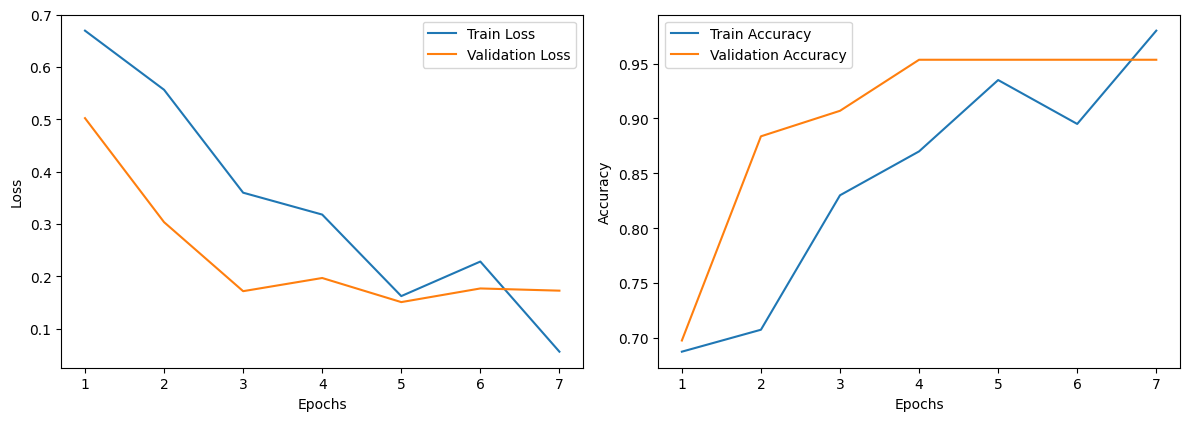

In [20]:
plot_metrics(model1_train_losses, model1_val_losses, model1_train_accuracies, model1_val_accuracies)

In [21]:
# Load the best model
model1.load_state_dict(torch.load('/kaggle/working/model1_best_early_stopping.pth'))

<All keys matched successfully>

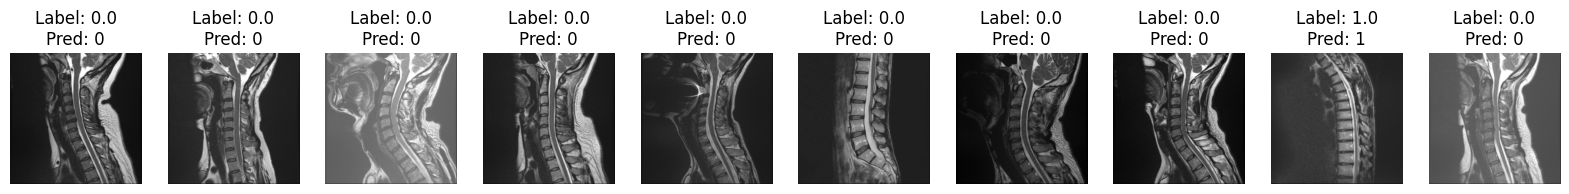

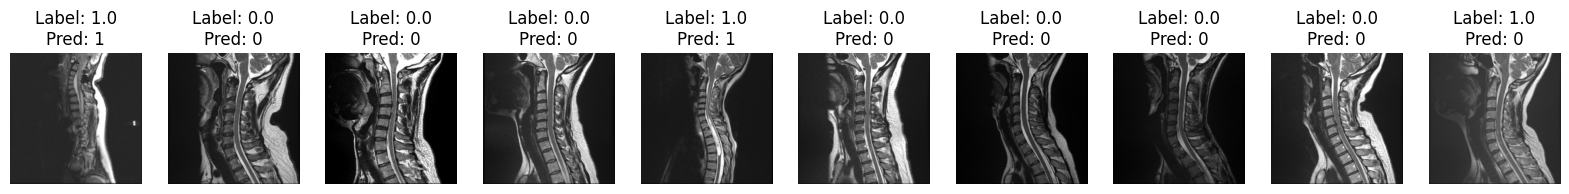

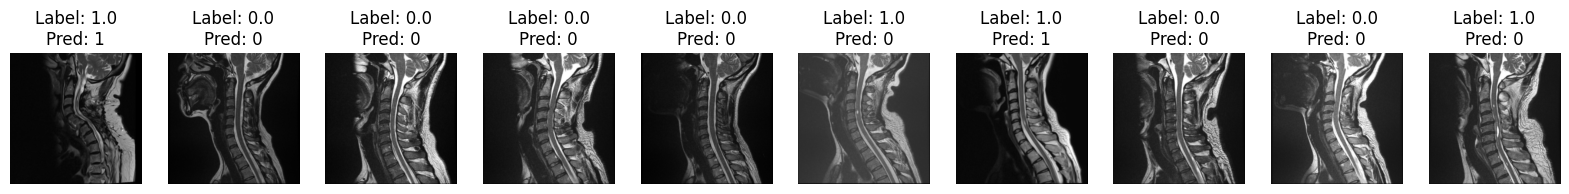

In [22]:
model1_labels, model1_preds = evaluate_and_show_predictions(model1,spine_test_loader, device)

Accuracy: 0.9091
Precision: 1.0000
Recall: 0.7647
F1 Score: 0.8667


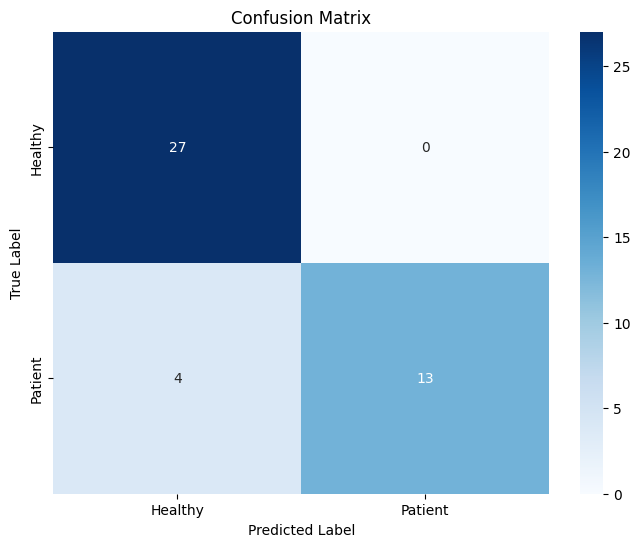

In [23]:
evaluate_metrics_and_confusion_matrix(model1_labels, model1_preds)

## EfficientNetV2

In [24]:
model2_metrics_df

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,0.613946,0.6825,0.605497,0.790698
1,2,0.330999,0.8950,0.321410,0.837209
2,3,0.118852,0.9650,0.164254,0.953488
3,4,0.080573,0.9800,0.153025,0.953488
4,5,0.063524,0.9850,0.168529,0.953488
5,6,0.048409,0.9825,0.138598,0.953488
6,7,0.033910,0.9925,0.104161,0.976744
7,8,0.022186,0.9950,0.108824,0.976744
8,9,0.029062,0.9900,0.073724,0.953488
9,10,0.015681,0.9975,0.090310,0.953488


Best Validation Loss: 0.0737 at Epoch: 9
Validation Accuracy at Best Epoch: 0.9535


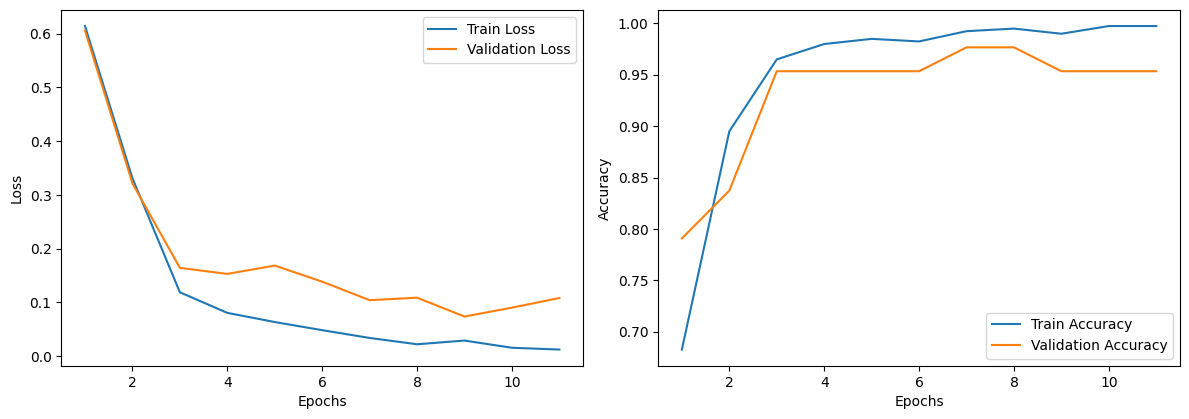

In [25]:
plot_metrics(model2_train_losses, model2_val_losses, model2_train_accuracies, model2_val_accuracies)

In [26]:
model2.load_state_dict(torch.load('/kaggle/working/model2_best_early_stopping.pth'))

<All keys matched successfully>

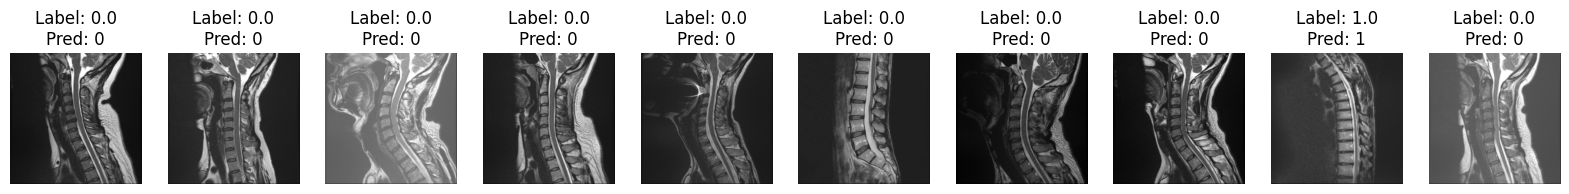

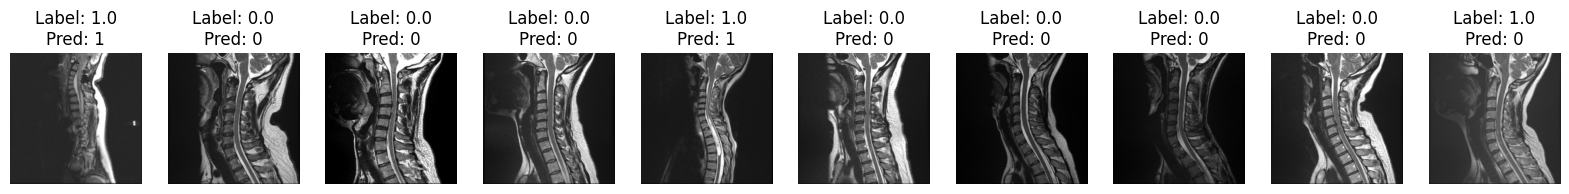

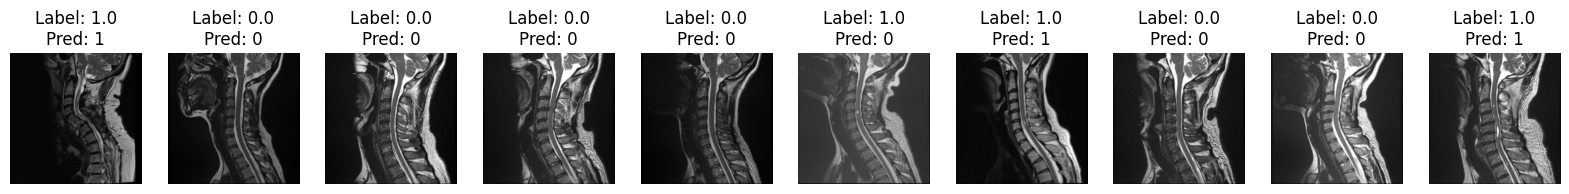

In [27]:
model2_labels, model2_preds = evaluate_and_show_predictions(model2,spine_test_loader, device)

Accuracy: 0.9545
Precision: 1.0000
Recall: 0.8824
F1 Score: 0.9375


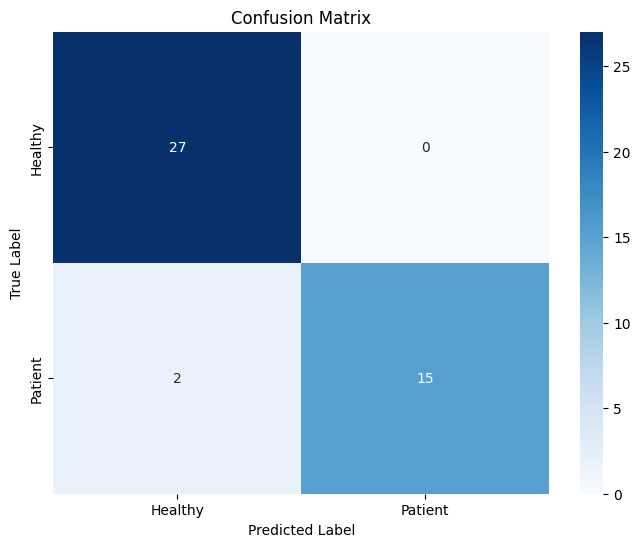

In [28]:
evaluate_metrics_and_confusion_matrix(model2_labels, model2_preds)

## ResNet18 Model

In [29]:
# Display the metrics table
model3_metrics_df

,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,1,0.426403,0.7775,1.290707,0.511628
1,2,0.176981,0.9350,0.974231,0.651163
2,3,0.077984,0.9700,0.153815,0.930233
3,4,0.052942,0.9800,0.204468,0.906977
4,5,0.030350,0.9925,0.226583,0.930233


Best Validation Loss: 0.1538 at Epoch: 3
Validation Accuracy at Best Epoch: 0.9302


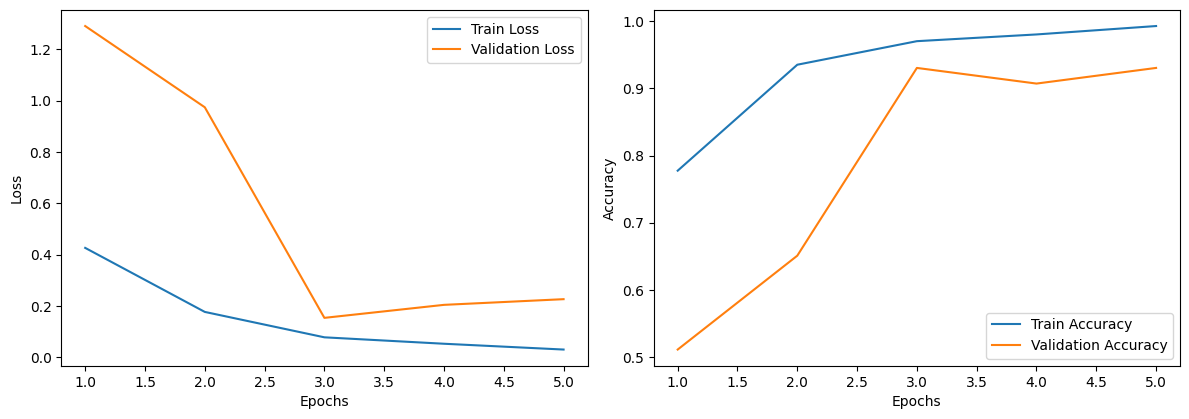

In [30]:
plot_metrics(model3_train_losses, model3_val_losses, model3_train_accuracies, model3_val_accuracies)

In [31]:
# Load the best model
model3.load_state_dict(torch.load('/kaggle/working/model3_best_early_stopping.pth'))

<All keys matched successfully>

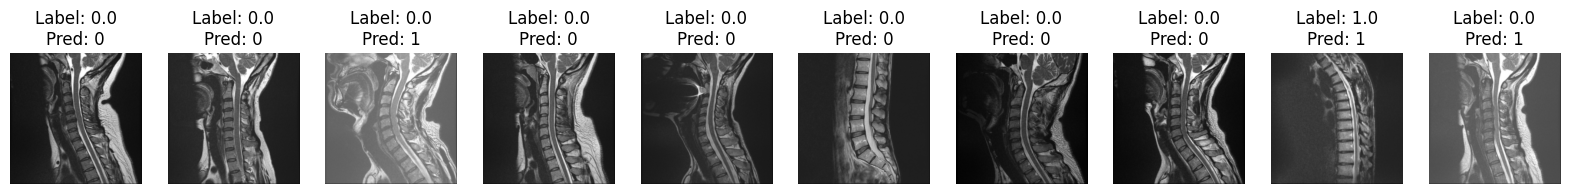

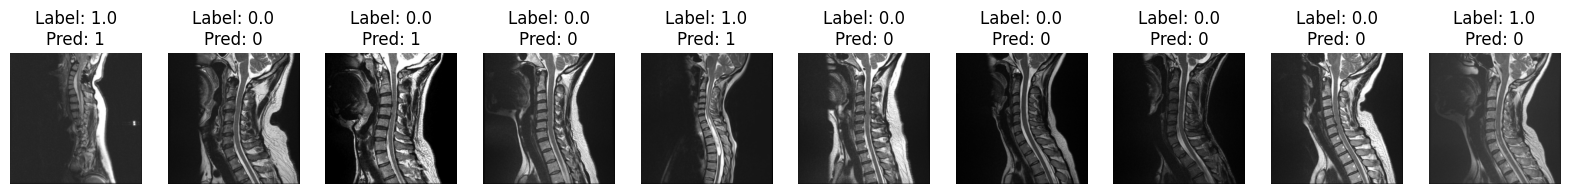

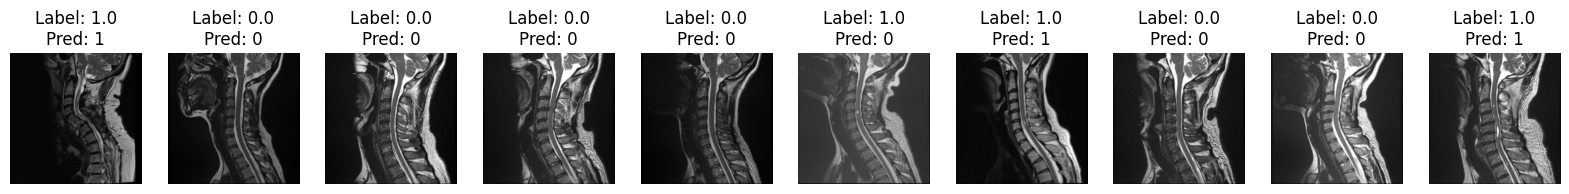

In [32]:
model3_labels, model3_preds = evaluate_and_show_predictions(model3,spine_test_loader, device)

Accuracy: 0.8636
Precision: 0.8235
Recall: 0.8235
F1 Score: 0.8235


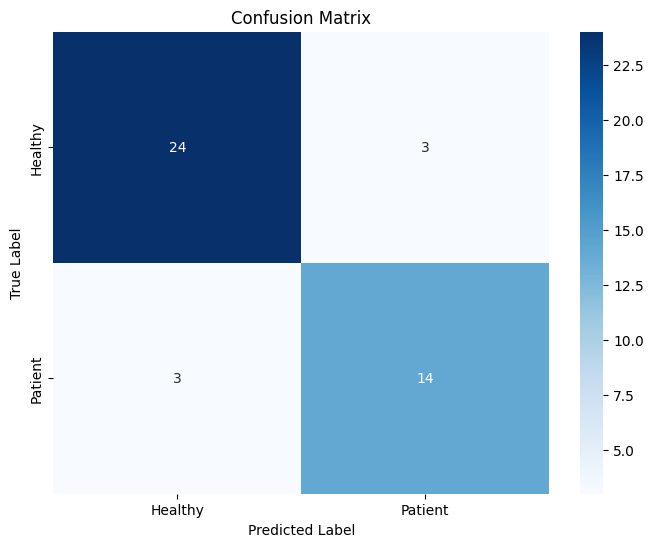

In [33]:
evaluate_metrics_and_confusion_matrix(model3_labels, model3_preds)

# ENSEMBLE LEARNING

In [34]:
def get_model_predictions(model, loader, device):
    """
    Get predictions from a model on the loader's dataset.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            #predicted = (preds > 0.5).long()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

def ensemble_predictions(models, loader, device, threshold=0.5):
    """
    Perform an ensemble of multiple models using average probabilities.
    
    Args:
    - models (list): List of models to ensemble.
    - loader (DataLoader): DataLoader for the dataset.
    - device (torch.device): Device to run the models on (CPU or GPU).
    - threshold (float): Threshold for converting probabilities to binary predictions.
    
    Returns:
    - all_labels: True labels from the dataset.
    - ensemble_preds: Final binary predictions from the ensemble.
    """
    # Initialize lists to store predictions from each model
    all_model_preds = []
    all_labels = None

    # Collect predictions from each model
    for model in models:
        labels, model_preds = get_model_predictions(model, loader, device)
        all_model_preds.append(model_preds)
        if all_labels is None:
            all_labels = labels  # Store labels from the first model (all labels should be the same)
    #print(all_model_preds)
    # Stack model predictions along axis 0 to create an array of shape (num_models, num_samples)
    stacked_preds = np.stack(all_model_preds, axis=0)

    # Average the predictions across all models
    averaged_preds = np.mean(stacked_preds, axis=0)

    # Apply threshold to averaged predictions to get final binary predictions
    ensemble_preds = (averaged_preds > threshold).astype(int)
    
    return all_labels, ensemble_preds

## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Get predictions from all models on the training dataset
model1_train_labels, model1_train_preds = get_model_predictions(model1, spine_train_loader, device)
model2_train_labels, model2_train_preds = get_model_predictions(model2, spine_train_loader, device)
model3_train_labels, model3_train_preds = get_model_predictions(model3, spine_train_loader, device)

# Ensure that labels are the same for all models
assert np.array_equal(model1_train_labels, model2_train_labels)
assert np.array_equal(model1_train_labels, model3_train_labels)

# Step 2: Combine predictions to create the meta-features
meta1_features_train = np.hstack([
    model1_train_preds.reshape(-1, 1),
    model2_train_preds.reshape(-1, 1),
    model3_train_preds.reshape(-1, 1)
])
meta1_labels_train = model1_train_labels  # These are the true labels

# Step 3: Train a Logistic Regression model as the meta-learner
meta1_learner = LogisticRegression()
meta1_learner.fit(meta1_features_train, meta1_labels_train.ravel())

# Step 4: Get predictions from all models on the test dataset
model1_test_labels, model1_test_preds = get_model_predictions(model1, spine_test_loader, device)
model2_test_labels, model2_test_preds = get_model_predictions(model2, spine_test_loader, device)
model3_test_labels, model3_test_preds = get_model_predictions(model3, spine_test_loader, device)

# Ensure that labels are the same for all models
assert np.array_equal(model1_test_labels, model2_test_labels)
assert np.array_equal(model1_test_labels, model3_test_labels)

# Step 5: Combine test predictions to create the meta-features for the test dataset
meta1_features_test = np.hstack([
    model1_test_preds.reshape(-1, 1),
    model2_test_preds.reshape(-1, 1),
    model3_test_preds.reshape(-1, 1)
])
meta1_labels_test = model1_test_labels

# Step 6: Use the meta-learner to make predictions
meta1_test_preds = meta1_learner.predict(meta1_features_test)

# Step 7: Evaluate the meta-learner's performance
meta1_accuracy = accuracy_score(meta1_labels_test, meta1_test_preds)
print(f"Meta-Learner Accuracy: {meta1_accuracy:.4f}")


Meta-Learner Accuracy: 0.9318


Accuracy: 0.9318
Precision: 0.9375
Recall: 0.8824
F1 Score: 0.9091


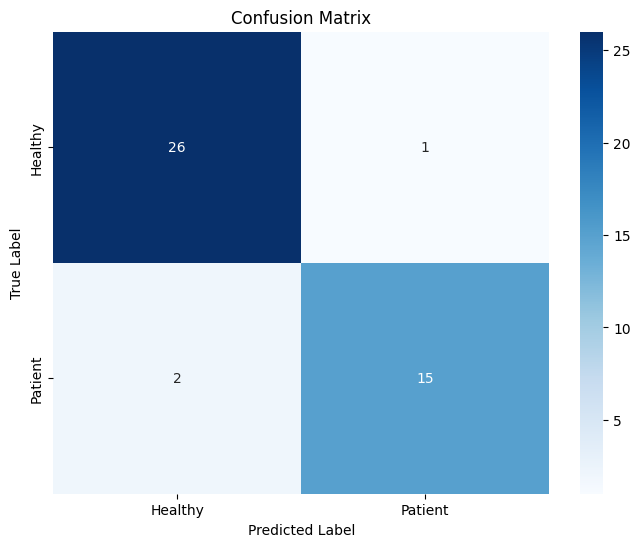

In [36]:
evaluate_metrics_and_confusion_matrix(meta1_labels_test, meta1_test_preds)

## Averaging Ensemble

Accuracy: 0.9091
Precision: 0.9333
Recall: 0.8235
F1 Score: 0.8750


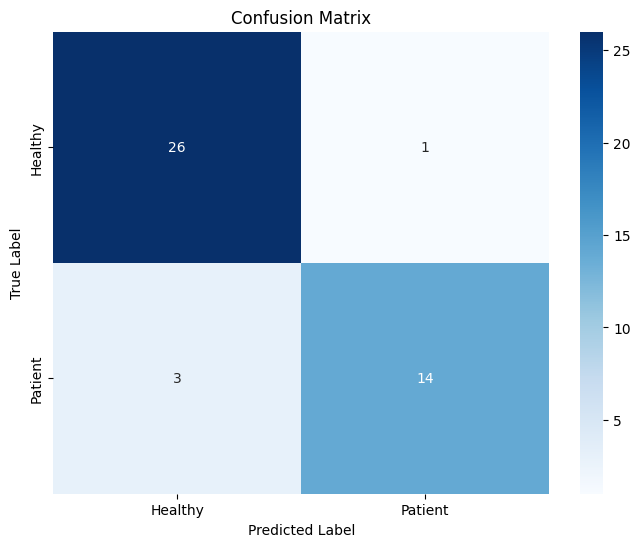

In [37]:
# List of models to ensemble
models = [model1, model2, model3]

# Get ensemble predictions
ensemble_labels, ensemble_preds = ensemble_predictions(models, spine_test_loader, device)

# Evaluate metrics (accuracy, precision, recall, F1, etc.)
evaluate_metrics_and_confusion_matrix(ensemble_labels, ensemble_preds)

In [38]:
# Step 1: Get predictions (probabilities for soft voting) from all models
model1_labels, model1_probs = get_model_predictions(model1, spine_test_loader, device)
model2_labels, model2_probs = get_model_predictions(model2, spine_test_loader, device)
model3_labels, model3_probs = get_model_predictions(model3, spine_test_loader, device)

# Ensure that the labels are the same for all models
assert np.array_equal(model1_labels, model2_labels)
assert np.array_equal(model1_labels, model3_labels)

# Step 2: Hard Voting
# Convert probabilities to class predictions (0 or 1) based on a 0.5 threshold
model1_preds = (model1_probs > 0.5).astype(int)
model2_preds = (model2_probs > 0.5).astype(int)
model3_preds = (model3_probs > 0.5).astype(int)

# Stack all model predictions and perform hard voting (majority vote)
hard_voting_preds = np.stack([model1_preds, model2_preds, model3_preds], axis=1)
hard_voting_final_preds = np.round(np.mean(hard_voting_preds, axis=1)).astype(int)

# Step 3: Soft Voting
# Simply average the probabilities of all models for soft voting
soft_voting_probs = np.mean(np.stack([model1_probs, model2_probs, model3_probs], axis=1), axis=1)
soft_voting_final_preds = (soft_voting_probs > 0.5).astype(int)

# Step 4: Evaluate both voting methods
hard_voting_accuracy = accuracy_score(model1_labels, hard_voting_final_preds)
soft_voting_accuracy = accuracy_score(model1_labels, soft_voting_final_preds)

print(f"Hard Voting Accuracy: {hard_voting_accuracy:.4f}")
print(f"Soft Voting Accuracy: {soft_voting_accuracy:.4f}")

Hard Voting Accuracy: 0.9318
Soft Voting Accuracy: 0.9091
